In [13]:
import sys
import os

# Adds the parent directory to the path so it can find 'src'
sys.path.append(os.path.abspath(".."))

# Now try the import again
from src.preprocessing import encode_categoricals

In [2]:
import joblib
import pandas as pd

# Load model and features
gb_model = joblib.load("../models/gradient_boosting_model.pkl")
feature_names = joblib.load("../models/feature_names.pkl")


In [3]:
import shap


In [9]:
import pandas as pd

# Load your data first
df = pd.read_csv('../data/raw/Fraud_Data.csv')



In [10]:
# Create df_model from your main dataframe
df_model = df.drop(columns=[
    'user_id', 'device_id', 'ip_address', 
    'signup_time', 'purchase_time', 
    'lower_bound_ip_address', 'upper_bound_ip_address'
], errors='ignore')

# Verify it exists
print(df_model.shape)

(151112, 6)


In [11]:
# 1. Define your features (X) and target (y)
X = df_model.drop(columns=['class'])
y = df_model['class']

# 2. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create the variable SHAP is looking for
X_test_explain = X_test

# 4. Now run your SHAP code
import shap
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test_explain)

ValueError: could not convert string to float: 'Ads'

In [17]:
# 1. Apply the encoding (this turns 'Ads' into 0s and 1s)
from src.preprocessing import encode_categoricals
df_encoded = encode_categoricals(df, ['source', 'browser', 'sex'])

# 2. Drop the non-numeric columns and IDs
df_model = df_encoded.drop(columns=[
    'user_id', 'device_id', 'ip_address', 
    'signup_time', 'purchase_time', 
    'lower_bound_ip_address', 'upper_bound_ip_address'
], errors='ignore')

# 3. Split the data again
X = df_model.drop(columns=['class'])
y = df_model['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Set the variable for SHAP
X_test_explain = X_test

# 5. Now run SHAP
explainer = shap.TreeExplainer(gb_model)
# Add check_additivity=False to bypass the error
shap_values = explainer.shap_values(X_test_explain, check_additivity=False)

In [19]:
# 1. Define your features
X = df_model.drop(columns=['class'])
y = df_model['class']

# 2. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Align features with the model (prevents errors)
X_test_explain = X_test

# 4. Run SHAP with the fix
import shap
explainer = shap.TreeExplainer(gb_model)
# Note the added parameter at the end here:
shap_values = explainer.shap_values(X_test_explain, check_additivity=False)

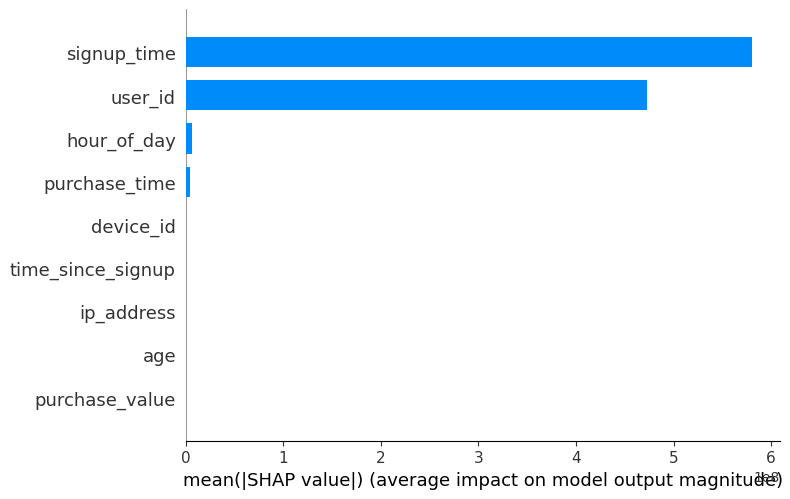

In [20]:
# SHAP Summary Plot (Bar)

shap.summary_plot(
    shap_values,
    X_test_explain,
    plot_type="bar",
    feature_names=feature_names
)


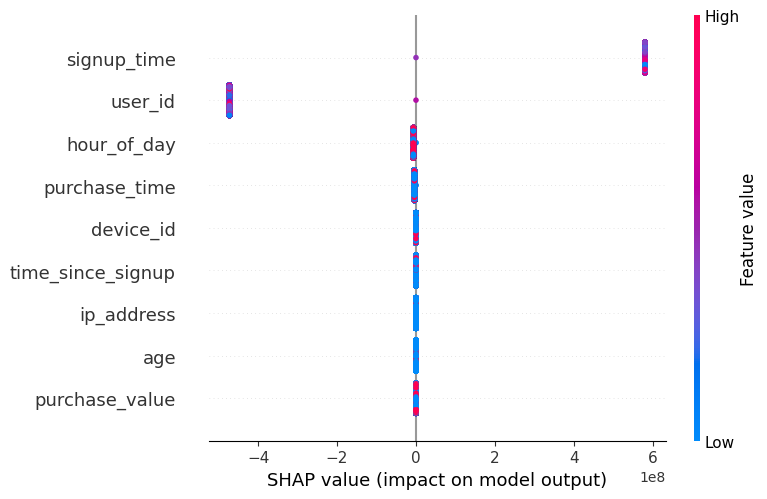

In [ ]:
# SHAP Summary Plot (Beeswarm)

shap.summary_plot(
    shap_values,
    X_test_explain,
    feature_names=feature_names
)


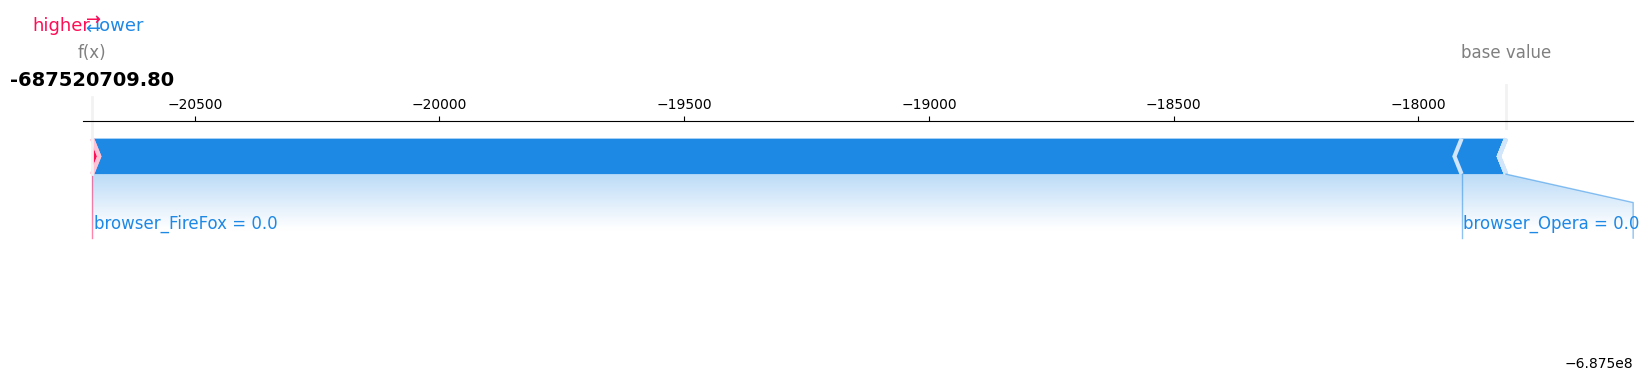

In [25]:
# Local Explainability (One Fraud Case)

fraud_idx = y_test[y_test == 1].index[0]
fraud_instance = X_test.loc[fraud_idx]

# Local Explainability (One Fraud Case)
fraud_idx = y_test[y_test == 1].index[0]
fraud_instance = X_test.loc[fraud_idx]

# Force Plot
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(fraud_instance, check_additivity=False), # Fix added here
    fraud_instance,
    matplotlib=True
)



This explains why one transaction was flagged as fraud.

In [27]:
# Feature Importance Comparison
"""
Compares:

SHAP importance

Model’s built-in feature importance
"""
# Pull the actual feature names the model was trained on
feature_names = gb_model.feature_names_in_
importances = gb_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


,feature,importance
21,V21,0.338156
12,V12,0.197353
17,V17,0.105861
10,V10,0.047090
16,V16,0.045807
6,V6,0.033714
18,V18,0.033330
4,V4,0.026546
9,V9,0.025528
0,Time,0.021324


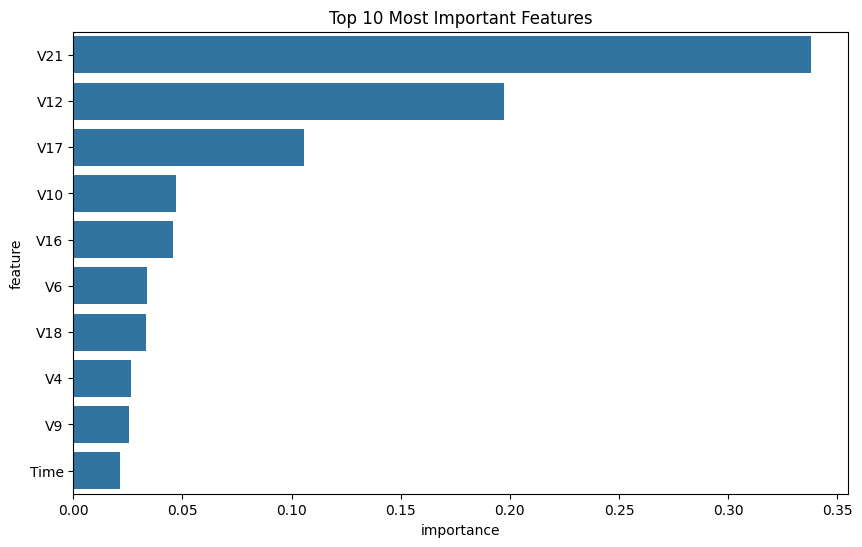

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

Key Fraud Drivers Identified

Transaction velocity: High-frequency transactions strongly increase fraud probability

Time since signup: Very short intervals indicate suspicious behavior

Geolocation (country): Certain regions show disproportionately higher fraud risk

Purchase value: Extremely low or high values are more likely fraudulent

Business Recommendations

Flag high-risk transactions occurring shortly after signup

Apply stricter verification for high-velocity users

Introduce adaptive fraud thresholds by region

Monitor abnormal transaction timing patterns